Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 17 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - accuracy: 0.1526 - loss: 2.0048
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step - accuracy: 0.4804 - loss: 1.5983
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.2426 - loss: 1.6139
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.1473 - loss: 1.5502
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.1454 - loss: 1.5536
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.4510 - loss: 1.3956
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.2583 - loss: 1.5866
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.2045 - loss: 1.5131
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.2426 - loss: 1.4071 
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.4124 - loss: 1.3041


Saved artifact at '/tmp/tmpvfdk2tgl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor_27')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  140437781304656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140437668932752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140437668933328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140437668931600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140437668931984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140437668930832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140437668931408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140437668929296: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Model converted to TFLite!
🧠 Predicted Class: Cardboard


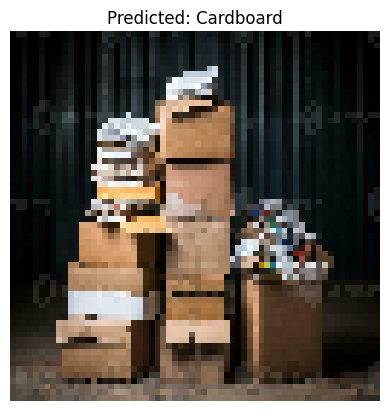

In [4]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Import libraries
import tensorflow as tf
import numpy as np
import os

IMG_SIZE = (64, 64)
BATCH_SIZE = 8

# STEP 3: Load images without validation split
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Trash Dataset',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# STEP 4: Build your CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

# STEP 5: Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# STEP 6: Train
model.fit(train_generator, epochs=10)

# STEP 7: Save the model
model.save('trash_classifier_model.h5')

# STEP 8: Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('trash_classifier_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ Model converted to TFLite!")

# STEP 9: Predict one image using TFLite
interpreter = tf.lite.Interpreter(model_path='trash_classifier_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict_image_tflite(image_path):
    from tensorflow.keras.preprocessing import image
    import matplotlib.pyplot as plt

    img = image.load_img(image_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data)

    class_labels = list(train_generator.class_indices.keys())
    print("🧠 Predicted Class:", class_labels[predicted_class])

    plt.imshow(img)
    plt.title(f"Predicted: {class_labels[predicted_class]}")
    plt.axis("off")
    plt.show()

# Example prediction (edit if needed)
predict_image_tflite(train_generator.filepaths[0])
